In [1]:
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd

In [2]:
files = glob.glob('.\\data\\ha_temp_*.png')

In [3]:
# reference tick labels to determine y axis scale

tick_labels = {
    20: np.array([
        [1, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 0, 0, 1],
        [1, 1, 1, 0, 0, 1, 1],
        [1, 1, 0, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]
    ]),
    40: np.array([
        [1, 1, 1, 1, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 1],
        [1, 0, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 1],
        [1, 1, 1, 1, 0, 0, 1],
        [1, 1, 1, 0, 0, 0, 0]
    ])
}

residual = lambda x, y: np.sum(np.abs(x - y))

In [4]:
temp_list = []
names     = []

for file in files:

    # extract date from filename
    name = file.split('_')[-3]
    name = name[-2:] + '.' + name[4:6] + '.' + name[:4]
    names.append(name)

    # read image
    img = mpimg.imread(file)

    # grayscale image
    gray = img[..., :3].mean(axis=2)

    # Threshold: find dark pixels (line)
    line_mask = (gray > 0.6) * 1

    # determine y-axis scale by checking the tick labels (max either 20°C or 40°C)
    # find the closest tick label to the reference labels
    tick_label = line_mask[56:65, 30:37]
    y_max = min(tick_labels, key=lambda k: residual(tick_label, tick_labels[k]))

    # Extract the (topmost) y-pixel number of the line
    zero_mask = (line_mask == 0)
    line_y = zero_mask.argmax(axis=0).astype(float)
    line_y[~zero_mask.any(axis=0)] = np.nan

    # convert pixels to values
    # y-pixel 267 corresponds to temperature 0
    # y-pixel  66 corresponds to temperature y_max
    temp_list.append(y_max * (line_y[49:-26] - 267) / (66 - 267))

# x-pixel  48 corresponds to hour 0
# x-pixel -16 corresponds to hour 24
min_max_hour = 24 * (np.array([49, 960-26]) - 48) / (960-16 - 48)
hour = np.linspace(min_max_hour[0], min_max_hour[1], len(temp_list[-1]))

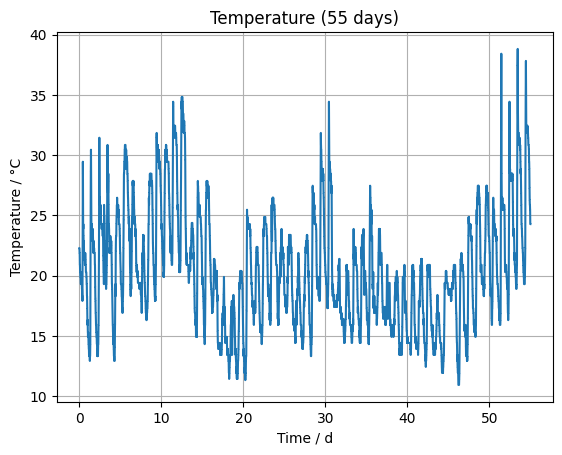

In [5]:
days      = np.concatenate([hour + 24 * i for i in range(len(temp_list))]) / 24
temp_flat = np.concatenate(temp_list)

# %matplotlib qt
plt.plot(days, temp_flat)
plt.title(f'Temperature ({len(temp_list)} days)')
plt.xlabel('Time / d')
plt.ylabel('Temperature / °C')
plt.grid()
plt.show()

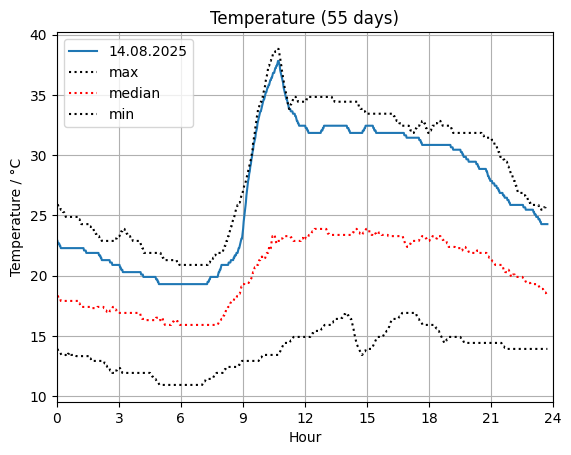

In [6]:
temperatures = pd.DataFrame(np.array(temp_list).T, index=hour, columns=names)

temperatures['median'] = temperatures.median(axis=1)
temperatures['min']    = temperatures.min(axis=1)
temperatures['max']    = temperatures.max(axis=1)

temperatures.plot(y=[name,'max','median','min'], style=['-','k:','r:','k:'], 
           title=f'Temperature ({temperatures.shape[1]-3} days)', 
           ylabel='Temperature / °C', xlabel='Hour', grid=True, 
           xticks=np.arange(0, 25, 3), xlim=(0, 24) )
plt.show()